In [1]:
# Author: Marco Lugo
# Simple localization model, direct bounding box regression using convolutional neural networks
# Achieves ~2.5 MAE

import numpy as np

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

from utils import datasets

img_size = 128
nb_epochs = 250

Using TensorFlow backend.


In [2]:
X_train, Y_train_masks, Y_train_classes, X_val, Y_val_masks, Y_val_classes, Y_train_bbox, Y_val_bbox = datasets.load_data()

print(X_train.shape)
print(Y_train_bbox.shape)

print(X_val.shape)
print(Y_val_bbox.shape)

(1463, 128, 128, 3)
(1463, 4)
(337, 128, 128, 3)
(337, 4)


In [3]:
# Dropped augmentation here as Keras has no support for bounding box augmentation. 
#It could be implemented with a different generator.

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, Y_train_bbox)
validation_generator = test_datagen.flow(X_val, Y_val_bbox)

In [4]:
def build_model(img_size=128):
    inputs = Input((img_size, img_size, 3))
    x = BatchNormalization()(inputs)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalMaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    outputs = Dense(4)(x) # Activation is f(x) = x

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_model()
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        2320      
__________

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, verbose=1)
checkpoint = ModelCheckpoint('loc1_best.h5', monitor='val_loss', save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0)

model.fit_generator(train_generator, validation_data=validation_generator, epochs=nb_epochs,
                        verbose=1, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/250
46/46 [==============================] - 5s 107ms/step - loss: 44.6313 - val_loss: 50.4743
Epoch 2/250
46/46 [==============================] - 2s 47ms/step - loss: 42.3744 - val_loss: 63.1708
Epoch 3/250
46/46 [==============================] - 2s 49ms/step - loss: 39.2733 - val_loss: 55.7481
Epoch 4/250
46/46 [==============================] - 2s 52ms/step - loss: 33.6694 - val_loss: 34.9461
Epoch 5/250
46/46 [==============================] - 2s 52ms/step - loss: 25.5620 - val_loss: 25.4839
Epoch 6/250
46/46 [==============================] - 2s 52ms/step - loss: 19.1336 - val_loss: 25.3072
Epoch 7/250
46/46 [==============================] - 2s 53ms/step - loss: 16.1101 - val_loss: 17.0944
Epoch 8/250
46/46 [==============================] - 2s 49ms/step - loss: 14.5710 - val_loss: 22.8655
Epoch 9/250
46/46 [==============================] - 2s 49ms/step - loss: 14.2458 - val_loss: 24.1830
Epoch 10/250
46/46 [==============================] - 2s 53ms/step - loss: 12.871

Epoch 82/250
46/46 [==============================] - 2s 53ms/step - loss: 7.4756 - val_loss: 2.6017
Epoch 83/250
46/46 [==============================] - 2s 49ms/step - loss: 7.2548 - val_loss: 2.8124
Epoch 84/250
46/46 [==============================] - 2s 49ms/step - loss: 7.3438 - val_loss: 3.3979
Epoch 85/250
46/46 [==============================] - 2s 49ms/step - loss: 7.2565 - val_loss: 2.9826
Epoch 86/250
46/46 [==============================] - 2s 49ms/step - loss: 7.4458 - val_loss: 2.7062
Epoch 87/250
46/46 [==============================] - 2s 49ms/step - loss: 7.4219 - val_loss: 2.7472
Epoch 88/250
46/46 [==============================] - 2s 49ms/step - loss: 7.3087 - val_loss: 2.8247
Epoch 89/250
46/46 [==============================] - 2s 49ms/step - loss: 7.2572 - val_loss: 2.6261
Epoch 90/250
46/46 [==============================] - 2s 49ms/step - loss: 7.0660 - val_loss: 2.6401
Epoch 91/250
46/46 [==============================] - 2s 54ms/step - loss: 7.2250 - val_los

In [6]:
model = load_model('loc1_best.h5')
preds = model.predict(X_val)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_img(img, x, y, w, h):
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle((x,y), w, h,linewidth=1, edgecolor='r', fill=False)
    ax.add_patch(rect)
    plt.show()
    return
    
def show_pred(i):
    show_img(X_val[i], preds[i,0], preds[i,1], preds[i,2], preds[i,3])
    #show_img(X_val[i], Y_val_bbox[i,0], Y_val_bbox[i,1], Y_val_bbox[i,2], Y_val_bbox[i,3])
    return

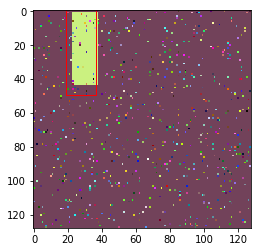

In [8]:
show_pred(5)

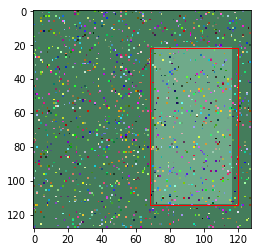

In [9]:
show_pred(36)

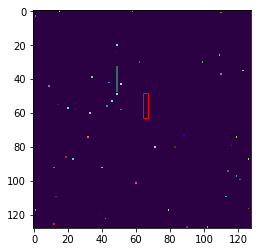

In [10]:
show_pred(9)

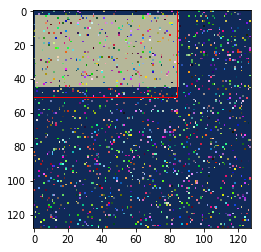

In [11]:
show_pred(54)

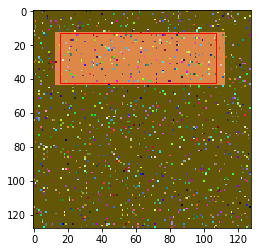

In [12]:
show_pred(91)

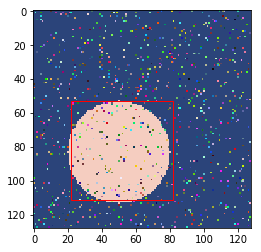

In [13]:
show_pred(280)

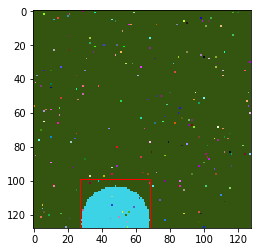

In [14]:
show_pred(303)

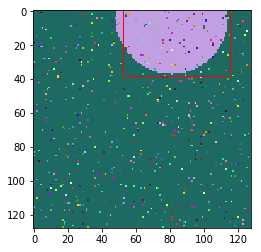

In [15]:
show_pred(330)